<a href="https://colab.research.google.com/github/ASHWINKUMAR1996/ProductRelevance/blob/master/ProductRelevance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar -xf spark-2.3.1-bin-hadoop2.7.tgz
# !mv spark-2.3.1-bin-hadoop2.7 spark
!pip install -q findspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"
# os.environ["PATH"] += os.environ["SPARK_HOME"] + "/bin" + os.pathsep + os.environ["SPARK_HOME"] + "/sbin"
os.environ["NLTK_DATA"] = "/content/drive/MyDrive/downloads/nltk"

import sys
sys.path.append("/content/drive/MyDrive/python3.7_packages/")

import findspark
findspark.init()
print(findspark.find())

import sys
import re
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import bert
import nltk
import datetime
from collections import Counter
from operator import itemgetter
from Levenshtein import ratio
from nltk.corpus import stopwords
import transformers
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from wordcloud import WordCloud

stop = stopwords.words("english")
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.max_columns', None)

import spacy
nlp = spacy.load("en_core_web_sm")

/content/spark-2.3.1-bin-hadoop2.7


In [ ]:
# read data from files
train = pd.read_csv("/content/drive/MyDrive/home_depot_product_search_relevance/train.csv", encoding="ISO-8859-1")
test = pd.read_csv("/content/drive/MyDrive/home_depot_product_search_relevance/test.csv", encoding="ISO-8859-1")
description = pd.read_csv("/content/drive/MyDrive/home_depot_product_search_relevance/product_descriptions.csv", encoding="ISO-8859-1")
attributes = pd.read_csv("/content/drive/MyDrive/home_depot_product_search_relevance/attributes.csv", encoding="ISO-8859-1")
train.shape, test.shape, description.shape, attributes.shape

((74067, 5), (166693, 4), (124428, 2), (2044803, 3))

In [ ]:
def preprocess_text(s):

    if isinstance(s, str):
    
        s = s.lower()
        s = s.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation), ""))
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        s = re.sub(r"([0-9]+)(\s*)(inches|inch|in)\.?(\s*x\s*)([0-9]+)(\s*)(inches|inch|in)\.?", r"\1x\5in.", s)
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)(\s*)(foot|feet|ft)\.?(\s*x\s*)([0-9]+)(\s*)(foot|feet|ft)\.?", r"\1x\5ft.", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = s.replace("°"," degrees ")
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
        s = s.replace(" v "," volts ")
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        s = re.sub(r'(\d+[\s]{1}[\d]+\d*)+', lambda x: x.group(1).replace(" ", ""), s)
        s = re.sub(r" +", r" ", s)    
        return s
    else:
        return "null"

In [ ]:
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),shower only faucet,2.67


In [ ]:
description.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-du..."
1,100002,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coat..."
2,100003,"Classic architecture meets contemporary design in the Ensemble Curve series, made of solid Vikrell material, blending sleek, clean lines with gentle curves. Corner shelving is perfect for storing ..."
3,100004,The Grape Solar 265-Watt Polycrystalline PV Solar Panel bonus pack bundles 4 Grape Solar 265-Watt solar panels for extra savings. The Grape Solar 265-Watt Polycrystalline PV Solar Panel uses high ...
4,100005,"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperat..."


In [ ]:
attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connections and home repair projects
1,100001.0,Bullet02,Stronger than angled nailing or screw fastening alone
2,100001.0,Bullet03,Help ensure joints are consistently straight and strong
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [ ]:
# check most repeating attributes
attributes["name"].value_counts().head(20)

MFG Brand Name                 86250
Bullet02                       86248
Bullet03                       86226
Bullet04                       86174
Bullet01                       85940
Product Width (in.)            61137
Bullet05                       60529
Product Height (in.)           54698
Product Depth (in.)            53652
Product Weight (lb.)           45175
Bullet06                       44901
Color Family                   41508
Bullet07                       34349
Material                       31500
Color/Finish                   28564
Bullet08                       26645
Certifications and Listings    24583
Bullet09                       20567
Assembled Height (in.)         18299
Assembled Width (in.)          18263
Name: name, dtype: int64

In [ ]:
# group attributes based on product id and create a feature dictionary for each product
attributes["name"] = attributes["name"].apply(preprocess_text)
attributes["value"] = attributes["value"].apply(preprocess_text)
att_features = attributes.groupby("product_uid").agg({"name": lambda s: s.tolist(), "value": lambda x: x.tolist()}).reset_index()
att_features["features"] = att_features.apply(lambda x: dict(zip(x["name"], x["value"])), axis=1)
att_features.head()

,product_uid,name,value,features
0,100001.0,"[bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, bullet07, gauge, material, mfg brand name, number of pieces, product depth in , product height in , product weight lb , product width in ]","[versatile connector for various 90â degrees connections and home repair projects, stronger than angled nailing or screw fastening alone, help ensure joints are consistently straight and strong, d...","{'bullet01': 'versatile connector for various 90â degrees connections and home repair projects', 'bullet02': 'stronger than angled nailing or screw fastening alone', 'bullet03': 'help ensure joint..."
1,100002.0,"[application method, assembled depth in , assembled height in , assembled width in , bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, bullet07, bullet08, bullet10, bullet18, cleanup, co...","[brush roller spray, 663in. , 776in. , 663in. , revives wood and composite decks railings porches and boat docks also great for concrete pool decks patios and sidewalks, 100 acrylic solid color co...","{'application method': 'brush roller spray', 'assembled depth in ': '663in. ', 'assembled height in ': '776in. ', 'assembled width in ': '663in. ', 'bullet01': 'revives wood and composite decks ra..."
2,100003.0,"[built in flange, bullet01, bullet02, bullet03, bullet04, bullet05, caulkless, certifications and listings, color family, color finish, construction, drain included, drain location, exterior bath ...","[yes, slightly narrower for tighter spaces, designed with an 18in. apron, durable high gloss finish provides a smooth shiny surface that is easy to clean, conforms to ansi z1241 2 and csa b451 nat...","{'built in flange': 'yes', 'bullet01': 'slightly narrower for tighter spaces', 'bullet02': 'designed with an 18in. apron', 'bullet03': 'durable high gloss finish provides a smooth shiny surface th..."
3,100004.0,"[amperage amps , bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, charge controller included, electrical product type, inverter included, low voltage audible alarm, mfg brand name, moun...","[856, positive power tolerance 0 to 5watt. , anti reflective and anti soiling surface reduces power loss from dirt and dust, outstanding performance in low light irradiances environments, certifie...","{'amperage amps ': '856', 'bullet01': 'positive power tolerance 0 to 5watt. ', 'bullet02': 'anti reflective and anti soiling surface reduces power loss from dirt and dust', 'bullet03': 'outstandin..."
4,100005.0,"[bath faucet type, built in water filter, bullet01, bullet02, bullet03, bullet04, certifications and listings, color family, color finish, connection size in , faucet features, faucet included com...","[combo tub and shower, no, includes the trim kit only the rough in kit r10000 unbx is sold separately, includes the handle, maintains a balanced pressure of hot and cold water even when a valve is...","{'bath faucet type': 'combo tub and shower', 'built in water filter': 'no', 'bullet01': 'includes the trim kit only the rough in kit r10000 unbx is sold separately', 'bullet02': 'includes the hand..."


In [ ]:
att_features.isna().any()

product_uid    False
name           False
value          False
features       False
dtype: bool

In [ ]:
# merge train and test with product description and attributes 
# concat train and test to get a complete dataframe

train_df = pd.merge(train, description, on="product_uid", how="left")
test_df = pd.merge(test, description, on="product_uid", how="left")
train_df = pd.merge(train_df, att_features, on="product_uid", how="left")
test_df = pd.merge(test_df, att_features, on="product_uid", how="left")

train_shape = train_df.shape
test_shape = test_df.shape

df = pd.concat([train_df, test_df], axis=0)
df.reset_index(inplace=True, drop=True)

df["relevance"].fillna(0, inplace=True)
df["name"][df["name"].isna()] = df["name"][df["name"].isna()].apply(lambda x: [])
df["value"][df["value"].isna()] = df["value"][df["value"].isna()].apply(lambda x: [])
df["features"][df["features"].isna()] = df["features"][df["features"].isna()].apply(lambda x: {})

In [ ]:
df.isna().any()

id                     False
product_uid            False
product_title          False
search_term            False
relevance              False
product_description    False
name                   False
value                  False
features               False
dtype: bool

In [ ]:
# preprocess the text columns
df["product_title"] = df["product_title"].apply(preprocess_text)
df["search_term"] = df["search_term"].apply(preprocess_text)
df["product_description"] = df["product_description"].apply(preprocess_text)

In [ ]:
df.head()

,id,product_uid,product_title,search_term,relevance,product_description,name,value,features
0,2,100001,simpson strong tie 12 gauge angle,angle bracket,3.00,not only do angles make joints stronger they also provide more consistent straight corners simpson strong tie offers a wide variety of angles in various sizes and thicknesses to handle light duty ...,"[bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, bullet07, gauge, material, mfg brand name, number of pieces, product depth in , product height in , product weight lb , product width in ]","[versatile connector for various 90â degrees connections and home repair projects, stronger than angled nailing or screw fastening alone, help ensure joints are consistently straight and strong, d...","{'bullet01': 'versatile connector for various 90â degrees connections and home repair projects', 'bullet02': 'stronger than angled nailing or screw fastening alone', 'bullet03': 'help ensure joint..."
1,3,100001,simpson strong tie 12 gauge angle,l bracket,2.50,not only do angles make joints stronger they also provide more consistent straight corners simpson strong tie offers a wide variety of angles in various sizes and thicknesses to handle light duty ...,"[bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, bullet07, gauge, material, mfg brand name, number of pieces, product depth in , product height in , product weight lb , product width in ]","[versatile connector for various 90â degrees connections and home repair projects, stronger than angled nailing or screw fastening alone, help ensure joints are consistently straight and strong, d...","{'bullet01': 'versatile connector for various 90â degrees connections and home repair projects', 'bullet02': 'stronger than angled nailing or screw fastening alone', 'bullet03': 'help ensure joint..."
2,9,100002,behr premium textured deckover 1gal. sc 141 tugboat wood and concrete coating,deck over,3.00,behr premium textured deckover is an innovative solid color coating it will bring your old weathered wood or concrete back to life the advanced 100 acrylic resin formula creates a durable coating ...,"[application method, assembled depth in , assembled height in , assembled width in , bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, bullet07, bullet08, bullet10, bullet18, cleanup, co...","[brush roller spray, 663in. , 776in. , 663in. , revives wood and composite decks railings porches and boat docks also great for concrete pool decks patios and sidewalks, 100 acrylic solid color co...","{'application method': 'brush roller spray', 'assembled depth in ': '663in. ', 'assembled height in ': '776in. ', 'assembled width in ': '663in. ', 'bullet01': 'revives wood and composite decks ra..."
3,16,100005,delta vero 1 handle shower only faucet trim kit in chrome valve not included,rain shower head,2.33,update your bathroom with the delta vero single handle shower faucet trim kit in chrome it has a sleek modern and minimalistic aesthetic the multichoice universal valve keeps the water temperature...,"[bath faucet type, built in water filter, bullet01, bullet02, bullet03, bullet04, certifications and listings, color family, color finish, connection size in , faucet features, faucet included com...","[combo tub and shower, no, includes the trim kit only the rough in kit r10000 unbx is sold separately, includes the handle, maintains a balanced pressure of hot and cold water even when a valve is...","{'bath faucet type': 'combo tub and shower', 'built in water filter': 'no', 'bullet01': 'includes the trim kit only the rough in kit r10000 unbx is sold separately', 'bullet02': 'includes the hand..."
4,17,100005,delta vero 1 handle shower only faucet trim kit in chrome valve not included,shower only faucet,2.67,update your bathroom with the delta vero single handle shower faucet trim kit in chrome it has a sleek modern and minimalistic aesthetic the multichoice universal valve keeps the water temperature...,"[bath faucet type, built in wat

(array([2.1050e+03, 3.0100e+03, 5.0000e+00, 6.7890e+03, 0.0000e+00,
        1.1730e+04, 1.6071e+04, 1.9000e+01, 1.5213e+04, 1.9125e+04]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

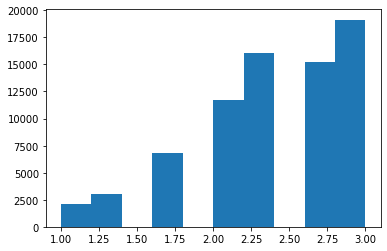

In [ ]:
# check the distribution of the relevance column
plt.hist(train.relevance, bins=10)

In [ ]:
# generate a wordcloud to get an idea of the most repeating words

# texts = " ".join(df["product_description"])
# wordcloud = WordCloud(width = 800, height = 800, stopwords = stop, min_font_size = 10).generate(texts)

# plt.figure(figsize = (8, 8))
# plt.imshow(wordcloud, interpolation='bilinear')

In [ ]:
train_df[(train_df["relevance"] <=3) & (train_df["relevance"] > 1)][["search_term", "product_title", "product_description", "relevance"]]

,search_term,product_title,product_description,relevance
0,angle bracket,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-du...",3.00
1,l bracket,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-du...",2.50
2,deck over,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coat...",3.00
3,rain shower head,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperat...",2.33
4,shower only faucet,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperat...",2.67
...,...,...,...,...
74061,rondec stainless steel 3/8 edge protection,Schluter Rondec Stainless Steel 3/8 in. x 1 in. Metal 90 Degree Outside Corner,The EV/RO100E is a prefabricated corner for Rondec that eliminates the need for a mitered edge. It is used to create 90 outside corners. The EV/RO100E corner is designed for use with the RO100E pr...,3.00
74063,r20 halogen light,Philips 40-Watt Halogen R20 Flood Light Bulb (12-Pack),"Philips Energy Advantage lamps use less energy while maintaining bright, crisp, white halogen light. Available in traditional lamp shapes to fit most incandescent fixtures. Halogen energy savers w...",3.00
74064,schlage lock siena half dummy knob with,Schlage Camelot In-Active Aged Bronze Handleset with Left-Hand Accent Lever,The Schlage Camelot In-Active Aged Bronze Handleset with Left-Hand Accent Lever is perfect for use as a decorative door pull on a pair of non-latching doors. The interior Accent lever is widely po...,2.33
74065,zen garden decor,Plastec 11 in. x 24 in. Rose Garden Wall Decor Steel,The Rose Garden is inspired by the popular early 20th century Scottish design motif. Dark Bronze powder coated finish on steel makes it suitable for indoor or outdoor use.Indoor and outdoor useFin...,3.00


In [ ]:
def check_word_presence(word, text):

  if word in text:
    return 1
  else:
    return 0

def check_ratio(query, text, mode="maximum"):
  
  if mode == "maximum":

    lev = [ratio(i, j) for i in query.split() for j in text.split() if i not in stop]
    if lev:
      return max(lev)
    else:
      return 0
  
  if mode == "total":
    lev = [max([ratio(i, j)  for j in text.split()]) for i in query.split() if i not in stop]
    return sum(lev)

In [ ]:
display_columns = [i for i in df.columns if i not in ["product_uid", "name", "value"]]

# find the count of words in the search query making sure the word is not a stopword
df["search_word_count"] = df["search_term"].apply(lambda x: len([i for i in x.split() if i not in stop]))

# split relevance values into bins [1, 2, 3]
df["relevance_bins"] = df["relevance"].apply(lambda x: np.floor(x) if not np.isnan(x) else 0.)

# find if the query is actually just a stopword, which might result in low relevancy
df["is_stopword"] = df["search_term"].apply(lambda x: x in stop).astype(int)

In [ ]:
# find the number of words in search term which are also present in product title and its ratio
df["word_in_title"] = df.apply(lambda x: sum([check_word_presence(i, x["product_title"].split()) for i in x["search_term"].split() if i not in stop]), axis=1)
df["ratio_word_in_title"] = df.apply(lambda x: x["word_in_title"] / (len([i for i in x["search_term"].split() if i not in stop]) + 1e-8), axis=1)

# find the number of words in search term which are also present in product description and its ratio
df["word_in_desc"] = df.apply(lambda x: sum([check_word_presence(i, x["product_description"].split()) for i in x["search_term"].split() if i not in stop]), axis=1)
df["ratio_word_in_desc"] = df.apply(lambda x: x["word_in_desc"] / (len([i for i in x["search_term"].split() if i not in stop]) + 1e-8), axis=1)

# find the levenshtein similarity between the search query word and words present in title and description
df["max_levenshtein_title"] = df.apply(lambda x: check_ratio(x["search_term"], x["product_title"], mode="maximum"), axis=1)
df["max_levenshtein_desc"] = df.apply(lambda x: check_ratio(x["search_term"], x["product_description"], mode="maximum"), axis=1)
df["total_levenshtein_title"] = df.apply(lambda x: check_ratio(x["search_term"], x["product_title"], mode="total"), axis=1)
df["total_levenshtein_desc"] = df.apply(lambda x: check_ratio(x["search_term"], x["product_description"], mode="total"), axis=1)

In [ ]:
df.head(2)

,id,product_uid,product_title,search_term,relevance,product_description,name,value,features,search_word_count,relevance_bins,is_stopword,word_in_title,ratio_word_in_title,word_in_desc,ratio_word_in_desc,max_levenshtein_title,max_levenshtein_desc,total_levenshtein_title,total_levenshtein_desc
0,2,100001,simpson strong tie 12 gauge angle,angle bracket,3.0,not only do angles make joints stronger they also provide more consistent straight corners simpson strong tie offers a wide variety of angles in various sizes and thicknesses to handle light duty ...,"[bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, bullet07, gauge, material, mfg brand name, number of pieces, product depth in , product height in , product weight lb , product width in ]","[versatile connector for various 90â degrees connections and home repair projects, stronger than angled nailing or screw fastening alone, help ensure joints are consistently straight and strong, d...","{'bullet01': 'versatile connector for various 90â degrees connections and home repair projects', 'bullet02': 'stronger than angled nailing or screw fastening alone', 'bullet03': 'help ensure joint...",2,3.0,0,1,0.5,0,0.0,1.000000,0.909091,1.333333,1.454545
1,3,100001,simpson strong tie 12 gauge angle,l bracket,2.5,not only do angles make joints stronger they also provide more consistent straight corners simpson strong tie offers a wide variety of angles in various sizes and thicknesses to handle light duty ...,"[bullet01, bullet02, bullet03, bullet04, bullet05, bullet06, bullet07, gauge, material, mfg brand name, number of pieces, product depth in , product height in , product weight lb , product width in ]","[versatile connector for various 90â degrees connections and home repair projects, stronger than angled nailing or screw fastening alone, help ensure joints are consistently straight and strong, d...","{'bullet01': 'versatile connector for various 90â degrees connections and home repair projects', 'bullet02': 'stronger than angled nailing or screw fastening alone', 'bullet03': 'help ensure joint...",2,2.0,0,0,0.0,0,0.0,0.333333,0.545455,0.666667,0.945455


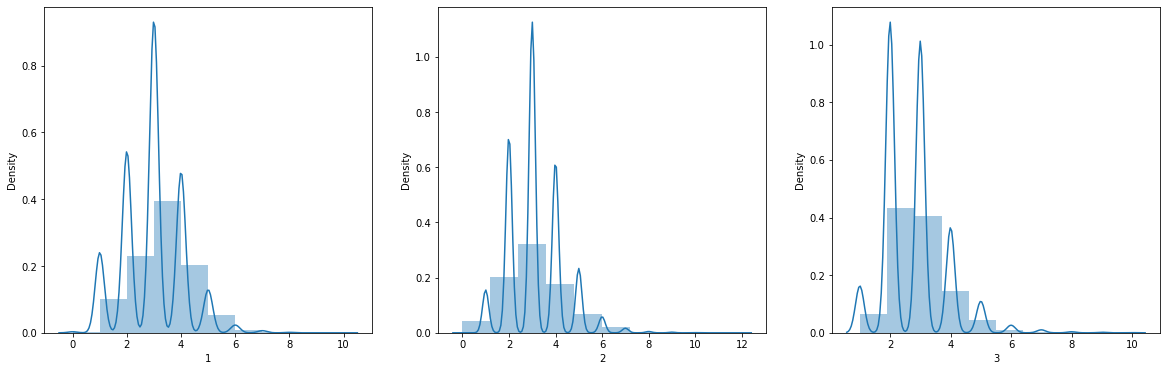

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(len(df["relevance_bins"].unique())):
  if i != 0:
    sns.distplot(df[df["relevance_bins"] == i]["search_word_count"], hist=True, bins=10, ax=ax[i - 1], axlabel=i)
plt.show()

In [ ]:
doc = nlp(df["product_description"].iloc[1])
spacy.displacy.render(doc, style="ent", jupyter=True)

In [ ]:
# df.to_csv("/content/drive/MyDrive/home_depot_product_search_relevance/temp.csv")
df = pd.read_csv("/content/drive/MyDrive/home_depot_product_search_relevance/temp.csv")
df.shape

(240760, 21)

In [ ]:
from pyspark.sql.types import *
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.driver.memory', '12g')\
        .config('spark.executor.memory', '12g')\
        .getOrCreate()

In [ ]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.app.name', 'Colab'),
 ('spark.app.id', 'local-1620454512478'),
 ('spark.driver.memory', '12g'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '5db56e375080'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '35987'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.executor.memory', '12g')]

In [ ]:
# spark.stop()

In [ ]:
"""sch = StructType([StructField("id", IntegerType(), True),
                  StructField("product_uid", IntegerType(), True),
                  StructField("product_title", StringType(), True),
                  StructField("search_term", StringType(), True),
                  StructField("relevance", FloatType(), True),
                  StructField("product_description", StringType(), True),
                  StructField("name", ArrayType(StringType()), True),
                  StructField("value", ArrayType(StringType()), True),
                  StructField("features", MapType(StringType(), StringType()), True),
                  StructField("word_in_title", IntegerType(), True),
                  StructField("ratio_word_in_title", FloatType(), True),
                  StructField("word_in_desc", IntegerType(), True),
                  StructField("ratio_word_in_desc", FloatType(), True),
                  StructField("search_word_count", IntegerType(), True),
                  StructField("relevance_bins", FloatType(), True),
                  StructField("is_stopword", IntegerType(), True),
                  StructField("total_levenshtein_title", FloatType(), True),
                  StructField("total_levenshtein_desc", FloatType(), True),
                  StructField("max_levenshtein_title", FloatType(), True),
                  StructField("max_levenshtein_desc", FloatType(), True)])"""

In [ ]:
%%time
spark_df = spark.createDataFrame(df.iloc[:50, :])
spark_df.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- id: long (nullable = true)
 |-- product_uid: long (nullable = true)
 |-- product_title: string (nullable = true)
 |-- search_term: string (nullable = true)
 |-- relevance: double (nullable = true)
 |-- product_description: string (nullable = true)
 |-- name: string (nullable = true)
 |-- value: string (nullable = true)
 |-- features: string (nullable = true)
 |-- search_word_count: long (nullable = true)
 |-- relevance_bins: double (nullable = true)
 |-- is_stopword: long (nullable = true)
 |-- word_in_title: long (nullable = true)
 |-- ratio_word_in_title: double (nullable = true)
 |-- word_in_desc: long (nullable = true)
 |-- ratio_word_in_desc: double (nullable = true)
 |-- max_levenshtein_title: double (nullable = true)
 |-- max_levenshtein_desc: double (nullable = true)
 |-- total_levenshtein_title: double (nullable = true)
 |-- total_levenshtein_desc: double (nullable = true)

CPU times: user 38.9 ms, sys: 2.27 ms, total: 41.1 ms


In [ ]:
spark_df.cache()
spark_df.count(), len(spark_df.columns)

(50, 21)

In [ ]:
spark_df.rdd.getNumPartitions()

1

In [ ]:
# create a function to get NER tags for the product description column
# load spacy model directly into worker node instead of driver in pyspark to avoid serialization

spacy_model = None
def get_spacy_model():
    global spacy_model
    if not spacy_model:
        _spacy = spacy.load("en_core_web_sm")
        spacy_model = _spacy
    
    return spacy_model      

# @pandas_udf(returnType=MapType(StringType(), IntegerType()), functionType=PandasUDFType.SCALAR)
def create_tags(text):
    nlp = get_spacy_model()
    tags = dict(sorted(Counter([i.label_ for i in nlp(text).ents]).items(), key=lambda x: x[1], reverse=True))
    return tags 

In [ ]:
# create a udf in pyspark
udf_new = F.udf(lambda x: create_tags(x), returnType=MapType(StringType(), IntegerType()))
spark_df = spark_df.withColumn("tags", udf_new("product_description"))

In [ ]:
spark_df.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- id: long (nullable = true)
 |-- product_uid: long (nullable = true)
 |-- product_title: string (nullable = true)
 |-- search_term: string (nullable = true)
 |-- relevance: double (nullable = true)
 |-- product_description: string (nullable = true)
 |-- name: string (nullable = true)
 |-- value: string (nullable = true)
 |-- features: string (nullable = true)
 |-- search_word_count: long (nullable = true)
 |-- relevance_bins: double (nullable = true)
 |-- is_stopword: long (nullable = true)
 |-- word_in_title: long (nullable = true)
 |-- ratio_word_in_title: double (nullable = true)
 |-- word_in_desc: long (nullable = true)
 |-- ratio_word_in_desc: double (nullable = true)
 |-- max_levenshtein_title: double (nullable = true)
 |-- max_levenshtein_desc: double (nullable = true)
 |-- total_levenshtein_title: double (nullable = true)
 |-- total_levenshtein_desc: double (nullable = true)
 |-- tags: map (nullable = true)
 |    |-- key: string


In [ ]:
%%time
spark_df.select(F.col("tags")).show(1, truncate=False)

+-----------------------------------------------------+
|tags                                                 |
+-----------------------------------------------------+
|[CARDINAL -> 4, PERSON -> 1, QUANTITY -> 1, GPE -> 1]|
+-----------------------------------------------------+
only showing top 1 row

CPU times: user 24.6 ms, sys: 973 µs, total: 25.6 ms
Wall time: 4.22 s


In [ ]:
# create one column for each of the NER tags to show their counts
keys_df = spark_df.select(F.explode(F.map_keys(F.col("tags")))).distinct().collect()
keys = list(map(lambda x: x[0], keys_df))

col = list(map(lambda x: F.col("tags").getItem(x).alias(x), keys))

temp_df = spark_df.select(cols).fillna(0)
temp_df.show(5, truncate=False)

+--------+----+------+----+---+-----+---+----+-----+---+--------+---+
|CARDINAL|DATE|PERSON|NORP|ORG|MONEY|LOC|TIME|EVENT|FAC|QUANTITY|GPE|
+--------+----+------+----+---+-----+---+----+-----+---+--------+---+
|4       |0   |1     |0   |0  |0    |0  |0   |0    |0  |1       |1  |
|4       |0   |1     |0   |0  |0    |0  |0   |0    |0  |1       |1  |
|4       |0   |0     |1   |1  |0    |0  |0   |0    |0  |1       |1  |
|1       |0   |0     |0   |0  |0    |0  |0   |0    |0  |0       |2  |
|1       |0   |0     |0   |0  |0    |0  |0   |0    |0  |0       |2  |
+--------+----+------+----+---+-----+---+----+-----+---+--------+---+
only showing top 5 rows



In [ ]:
spark_df = spark_df.withColumn("new_id", F.monotonically_increasing_id())
temp_df = temp_df.withColumn("new_id", F.monotonically_increasing_id())
result_df = spark_df.join(temp_df, "new_id", "inner").drop("new_id")
result_df.show(3, truncate=False)

In [ ]:
result_df.show(3, truncate=False)

+----------+---+-----------+-----------------------------------------------------------------------------+-------------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
pdf = result_df.toPandas()

In [ ]:
pdf["relevance_bins"].unique()

array([3., 2., 1.])

No handles with labels found to put in legend.


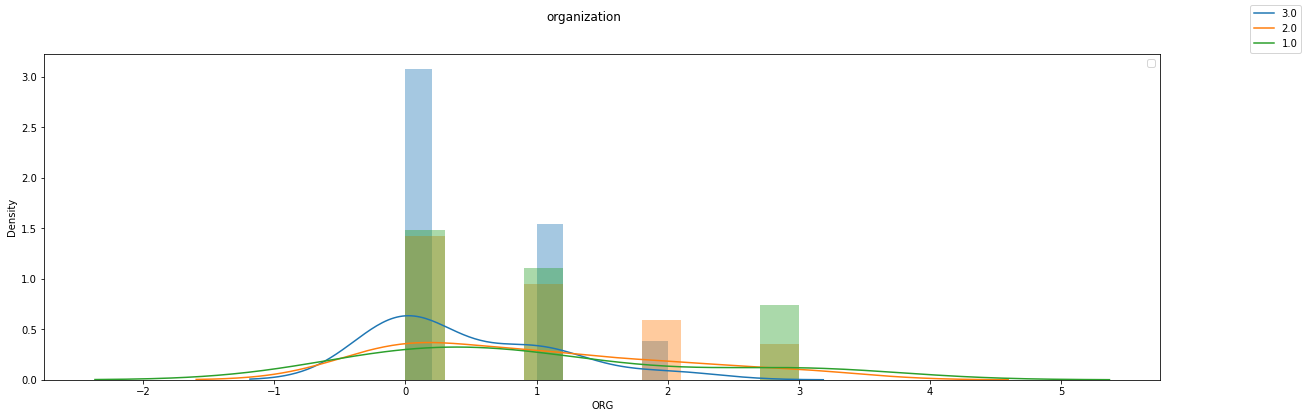

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

for i in pdf["relevance_bins"].unique():
    sns.distplot(pdf[pdf["relevance_bins"] == i]["ORG"], hist=True, bins=10, ax=ax)

fig.legend(pdf["relevance_bins"].unique())
plt.suptitle("organization")
plt.legend()
plt.show()

In [ ]:
df[(df["search_word_count"] == 1) & (df["relevance"] == 3) & (df["is_stopword"] == 0)].iloc[:, [2, 3, 5, -4, -3, -2, -1]]

,product_title,search_term,product_description,max_levenshtein_title,max_levenshtein_desc,total_levenshtein_title,total_levenshtein_desc
2,behr premium textured deckover 1gal. sc 141 tugboat wood and concrete coating,deck over,behr premium textured deckover is an innovative solid color coating it will bring your old weathered wood or concrete back to life the advanced 100 acrylic resin formula creates a durable coating ...,"(0.6666666666666666, deck, deckover)","(1.0, deck, deck)",0.666667,1.000000
7,whirlpool 19 cu ft over the range convection microwave in stainless steel with sensor cooking,microwaves,achieving delicious results is almost effortless with this whirlpool over the range microwave hood with convection cooking with 19 cu ft capacity you ll have room to prepare multiple dishes at onc...,"(0.9473684210526315, microwaves, microwave)","(0.9473684210526315, microwaves, microwave)",0.947368,0.947368
84,60in. x 150ft. 1010 remesh,wiremesh,the 60in. x 150ft. 1010 remesh provides expansion and contraction reinforcement to add strength when pouring concrete pads it is made from astm a615 material and covers up to 750 sq ft per roll pr...,"(0.8571428571428571, wiremesh, remesh)","(0.8571428571428571, wiremesh, remesh)",0.857143,0.857143
145,kaleen soho thames beige 4x6ft. area rug,4x6,soho thames beige 4x6ft. area rug is a fun and functional collection of hip designs it is as funky and cheeky as the neighborhood that bears its name soho is great finish and cool designs 100 wool...,"(0.6666666666666666, 4x6, 4x6ft.)","(0.6666666666666666, 4x6, 4x6ft.)",0.666667,0.666667
159,melnor adjustable rear trigger nozzle,melnor,this heavy duty melnor adjustable rear trigger nozzle features an adjustable tip that sprays from mist to jet so you can tackle a variety of watering jobs the nozzle s trigger lock feature allows ...,"(1.0, melnor, melnor)","(1.0, melnor, melnor)",1.000000,1.000000
...,...,...,...,...,...,...,...
72207,ge silicone ii 101oz. white kitchen and bath caulk,whitesilicone,the shower doesn t have to be off limits for a full day caulk the shower or tub with ge silicone ii kitchen and bath and reduce the wait time dramatically ge silicone ii 100 silicone adheres to a ...,"(0.7619047619047619, whitesilicone, silicone)","(0.7619047619047619, whitesilicone, silicone)",0.761905,0.761905
72455,fypon 36x24in. x 2in. polyurethane decorative peaked louver,fyrpon,designed to be both beautiful and functional louvers have been a useful design accent for centuries fypon offers two basic louver types functional venting and decorative non venting in a multitude...,"(0.9090909090909091, fyrpon, fypon)","(0.9090909090909091, fyrpon, fypon)",0.909091,0.909091
72518,behr marquee 200a 3 blushing apricot exterior paint,blushing,behr marquee exterior flat is a stain blocking paint and primer that features the most advanced dirt and fade technology from behr marquee creates a tough non stick surface that helps resists dirt...,"(1.0, blushing, blushing)","(0.6666666666666666, blushing, lasting)",1.000000,0.666667
72559,custom building products commercial 381 bright white 101oz. silicone caulk,whitesilicone,commercial 100 silicone caulk is designed for use in coves corners changes in plane and expansion joints associated with exterior and interior applications of tile and stone this caulk can be used...,"(0.7619047619047619, whitesilicone, silicone)","(0.7619047619047619, whitesilicone, silicone)",0.761905,0.761905


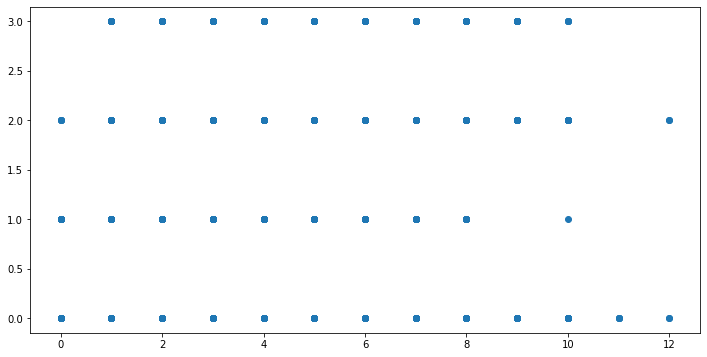

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df["search_word_count"], df["relevance_bins"])

In [ ]:
df[df["ratio_word_in_title"] > 1][display_columns]

,id,product_title,search_term,relevance,product_description,features,word_in_title,ratio_word_in_title,word_in_desc,ratio_word_in_desc


In [ ]:
train[train["relevance"] > 1][["search_term", "product_title", "product_description", "relevance"]]

,search_term,product_title,product_description,relevance
0,angle bracket,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-du...",3.00
1,l bracket,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-du...",2.50
2,deck over,BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating,"BEHR Premium Textured DECKOVER is an innovative solid color coating. It will bring your old, weathered wood or concrete back to life. The advanced 100% acrylic resin formula creates a durable coat...",3.00
3,rain shower head,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperat...",2.33
4,shower only faucet,Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included),"Update your bathroom with the Delta Vero Single-Handle Shower Faucet Trim Kit in Chrome. It has a sleek, modern and minimalistic aesthetic. The MultiChoice universal valve keeps the water temperat...",2.67
...,...,...,...,...
74061,rondec stainless steel 3/8 edge protection,Schluter Rondec Stainless Steel 3/8 in. x 1 in. Metal 90 Degree Outside Corner,The EV/RO100E is a prefabricated corner for Rondec that eliminates the need for a mitered edge. It is used to create 90 outside corners. The EV/RO100E corner is designed for use with the RO100E pr...,3.00
74063,r20 halogen light,Philips 40-Watt Halogen R20 Flood Light Bulb (12-Pack),"Philips Energy Advantage lamps use less energy while maintaining bright, crisp, white halogen light. Available in traditional lamp shapes to fit most incandescent fixtures. Halogen energy savers w...",3.00
74064,schlage lock siena half dummy knob with,Schlage Camelot In-Active Aged Bronze Handleset with Left-Hand Accent Lever,The Schlage Camelot In-Active Aged Bronze Handleset with Left-Hand Accent Lever is perfect for use as a decorative door pull on a pair of non-latching doors. The interior Accent lever is widely po...,2.33
74065,zen garden decor,Plastec 11 in. x 24 in. Rose Garden Wall Decor Steel,The Rose Garden is inspired by the popular early 20th century Scottish design motif. Dark Bronze powder coated finish on steel makes it suitable for indoor or outdoor use.Indoor and outdoor useFin...,3.00


In [ ]:
train["relevance"].min(), train["relevance"].max()

(1.0, 3.0)

### BERT EMBEDDINGS

In [ ]:
def bert_encode(tokenizer, bert_layer, texts, max_len, mode="pooled"):

    def convert_tokens(tokenizer, text, max_len):

        tokens = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))

        if len(tokens) <= max_len - 2:
            tokens.append(tokenizer.convert_tokens_to_ids(["[SEP]"])[0])
        else:
            tokens = tokens[:max_len - 2] + tokenizer.convert_tokens_to_ids(["[SEP]"])

        return tokens
    
    sentence = tf.ragged.constant([convert_tokens(tokenizer, i, max_len) for i in texts])
    cls_token = [tokenizer.convert_tokens_to_ids(["[CLS]"])] * len(texts)
    input_word = tf.concat([cls_token, sentence], axis=-1)

    mask = tf.ones_like(input_word).to_tensor()
    type_id = tf.zeros_like(input_word).to_tensor()

    inputs = {
    'input_word_ids': input_word.to_tensor(),
    'input_mask': mask,
    'input_type_ids': type_id}

    bert_embeddings = bert_layer(inputs)

    if mode == "pooled":
        return bert_embeddings["pooled_output"]

    else:
        return bert_embeddings["sequence_output"]

In [ ]:
# bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=False)
# bert_tokenizer = bert.bert_tokenization.FullTokenizer
# vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = bert_tokenizer(vocabulary_file, to_lower_case)

In [ ]:
# bert_embeddings = bert_encode(tokenizer, bert_layer, train["product_description"].tolist()[:5], max_len=300, mode="pooled")